In [87]:
import altair as alt
from vega_datasets import data
# alt.data_transformers.enable("vegafusion")

import pandas as pd
import geopandas as gpd
# import cartopy.crs as ccrs
# from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma
from scipy.optimize import curve_fit

import xarray as xr

import arviz as az
import pymc as pm

from tqdm.notebook import tqdm

In [3]:
fnm = "../data/external/woa23_decav91C0_t00_04.nc"
ds = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["t_an"]
# fnm = "../data/external/woa23_decav91C0_s00_04.nc"
# ds2 = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["s_an"]

ds


<xarray.DataArray 't_an' (depth: 27, lat: 720, lon: 1440)> Size: 112MB
[27993600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 108B 0.0 5.0 10.0 15.0 ... 175.0 200.0 225.0 250.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [4]:
df = pd.read_excel("../data/external/GDGTdata_Antarctica_220923.xlsx", sheet_name="iso modern cal",skiprows=1)
df

,Core name,Source,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',longitude,latitude,Sea Surface Temp,water depth,TEX86,Ring index
0,NBP0702-3,Tierney and Tingley 2015,0.541400,0.021900,0.006800,0.002400,0.424800,0.002600,-158.2700,-77.4700,-0.90,1081.0,0.350148,1.752300
1,NBP0702-10,Tierney and Tingley 2015,0.520800,0.015000,0.004000,0.001800,0.455500,0.002900,-108.6100,-74.1000,-1.70,730.0,0.367089,1.862000
2,NBP0702-13,Tierney and Tingley 2015,0.515200,0.020600,0.005700,0.003000,0.452700,0.002900,-134.5200,-73.9400,-1.80,470.0,0.360248,1.863400
3,NBP0702-15,Tierney and Tingley 2015,0.505600,0.023200,0.006400,0.002700,0.459000,0.003200,-125.8100,-72.5600,-1.60,425.0,0.346479,1.892900
4,NBP0702-22,Tierney and Tingley 2015,0.477800,0.034500,0.011300,0.003000,0.468300,0.005000,-104.0100,-71.7500,-1.80,665.0,0.358736,1.959300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,SO213/1_8-1,"Jaeshke et al., 2017",0.405664,0.057875,0.042174,0.004044,0.475397,0.014846,-95.3437,-37.4910,16.01,2171.0,0.513404,2.115326
971,SO213/1_6-1,"Jaeshke et al., 2017",0.454915,0.066376,0.044500,0.004564,0.416880,0.012765,-92.3805,-37.3560,16.05,2791.0,0.482269,1.887649
972,SO213/2_23-1,"Jaeshke et al., 2017",0.416182,0.068705,0.048834,0.004234,0.446719,0.015326,-100.6055,-36.6925,NaN,3430.0,0.498868,2.027256
973,O213/1_1-1,"Jaeshke et al., 2017",0.412693,0.068527,0.049505,0.006042,0.445106,0.018128,-85.0265,-36.2195,16.35,2806.0,0.518102,2.038597


0it [00:00, ?it/s]

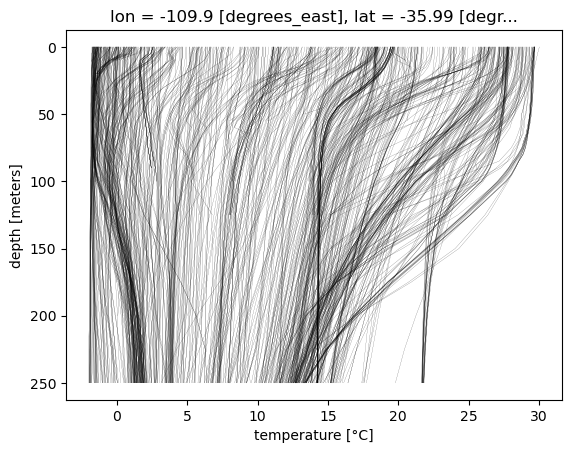

In [84]:
fig, ax = plt.subplots(1,1)

temps = []

woa_data = []

for name, row in tqdm(df.iterrows()):
    lon0, lat0 = row[["longitude","latitude"]].values
    T_profile = ds.interp(lon=lon0, lat=lat0, method="nearest")
    woa_data.append(np.sum(~np.isnan(T_profile.values)))
    temps.append(T_profile.values)
    T_profile.plot(y='depth',ax=ax,color='k',lw=0.1)
ax.invert_yaxis()
ax.set_xlabel("temperature [°C]")
df["woa_data"] = woa_data


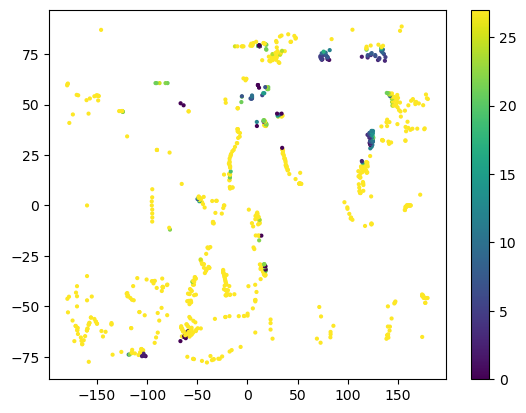

In [88]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(df["longitude"],df["latitude"],c=df["woa_data"],s=4)
plt.colorbar(im,ax=ax)

Core name                        GeoB10718-3
Source              Tierney and Tingley 2015
GDGT-0                                 0.347
GDGT-1                                 0.066
GDGT-2                                 0.039
GDGT-3                                 0.013
Crenarchaeol                           0.525
Cren'                                   0.01
longitude                             18.058
latitude                              39.693
Sea Surface Temp                        18.9
water depth                            219.0
TEX86                               0.484375
Ring index                             2.323
woa_data                                  27
Name: 546, dtype: object

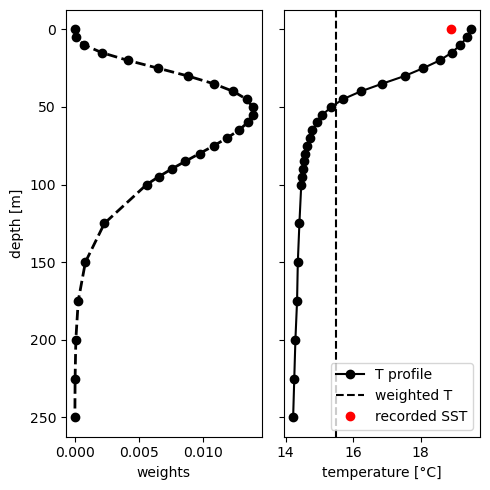

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(5,5), sharey=True)

a = 4.5
b = 15
z = ds.depth
weights = gamma.pdf(z, a, scale=b)

ax[0].plot(weights, z, 
       'ko--', lw=2, label='gamma pdf')
ax[0].invert_yaxis()
# ax[0].set_ylim(255,-5)
ax[0].set_xlabel("weights")
ax[0].set_ylabel("depth [m]")

idx = 546
display(df.iloc[idx])
ax[1].plot(temps[idx],z,'ko-',label='T profile')
valid = ~np.isnan(temps[idx])
T_avg = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
ax[1].axvline(T_avg,color='k',ls='--',label='weighted T')
ax[1].plot(df.iloc[idx]["Sea Surface Temp"],z[0], 'ro', label='recorded SST')

ax[1].set_xlabel("temperature [°C]")
ax[1].legend()
fig.tight_layout()

In [90]:
list(df.columns[2:8].astype(str).values)

['GDGT-0', 'GDGT-1', 'GDGT-2', 'GDGT-3', 'Crenarchaeol', "Cren'"]

In [91]:
def logistic(x,L,k,x0):
    return L/(1+np.exp(-k*(x-x0)))

(970,) (970,)
[0.06545054 0.16497836 0.44594698]


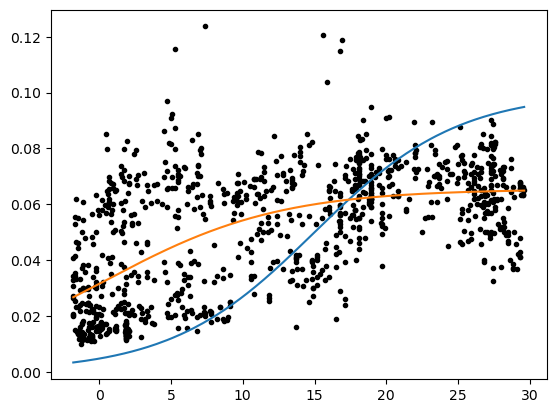

In [92]:
fig, ax = plt.subplots(1,1)


SST, y = df[["Sea Surface Temp","GDGT-1"]].dropna().values.T
print(SST.shape,y.shape)
ax.plot(SST,y,'k.')

L = 0.1
k = 0.2
x0 = 15
ax.plot(np.sort(SST),logistic(np.sort(SST),L, k,x0))

popt, pcov = curve_fit(logistic, SST, y)
print(popt)
ax.plot(np.sort(SST),logistic(np.sort(SST),*popt))

# Synthetic data

- *GDGT-0*, *GDGT-1*, *GDGT-2*, *GDGT-3*, *Crenarchaeol*, *Cren'* are *Dirichlet*-distributed, with a shape parameter $a$ of length 6.
- The $a$'s depend on temperature $\hat{T}$ and follow *logistic* function (S curves) with parameters $L$, $k$, and $a_0$. 
- Temperature $\hat{T}$ is the depth-averaged seawater temperature with *Gamma*-distributed weights with (global) parameters $\alpha$ and $\beta$.

In [93]:
rng = np.random.default_rng(1234)

N_GDGT = 6
L = rng.lognormal(size=N_GDGT)
L /= np.sum(L)
print(f"{L = }")

k = rng.normal(loc=0,scale=0.1, size=N_GDGT)
print(f"{k = }")

a = rng.lognormal(1,1,size=N_GDGT)
print(f"{a = }")

alpha = rng.normal(loc=5,scale=2)
print(f"{alpha = }")

beta = rng.normal(loc=15,scale=3)
print(f"{beta = }")

L = array([0.00794458, 0.04211593, 0.08286538, 0.04601398, 0.09369736,
       0.72736277])
k = array([-0.14788234,  0.0945473 , -0.16661355,  0.03437446, -0.05124437,
        0.1323759 ])
a = array([ 1.14995154,  4.56990857,  0.7670957 ,  0.31375621,  4.19852784,
       15.38340483])
alpha = 6.04026831247104
beta = 11.993502618736679


In [94]:
weights = gamma.pdf(z, alpha, scale=beta)

N_RECORDS = len(temps)
T_hats = []
for idx in tqdm(range(N_RECORDS)):
    valid = ~np.isnan(temps[idx])
    if sum(valid)>1:
        T_avg = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
    # else:
        # print(idx)

  0%|          | 0/975 [00:00<?, ?it/s]

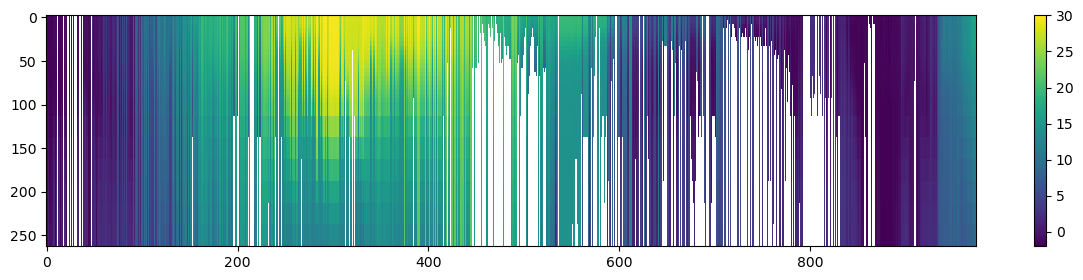

In [95]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
XX, YY = np.meshgrid(np.arange(N_RECORDS),z)
im  = ax.pcolormesh(XX,YY,np.array(temps).T)
plt.colorbar(im,ax=ax)
ax.invert_yaxis()